# Estrategia 05
---

En este archivo se buscó desarrollar una estrategia con el mayor indice de ```accuracy``` posible. Para esto se usaron las features con mejores resultados en estrategias anteriores y se uso un clasificador múltiple con el cuál se espera amortiguar problemas singulares para ciertos *patches*.

---
## 1) Carga de Datos

In [235]:
import numpy as np
import os

# data directory path
DATADIR = 'data'

# carga de datos de training
x_training = np.load(os.path.join(DATADIR, 'training', 'dataset_features.npy'), allow_pickle=True)
label_training = np.load(os.path.join(DATADIR, 'training', 'dataset_labels.npy'), allow_pickle=True)
d_train = np.array([int(y[1:3]) for y in label_training])

# carga de datos de testing
x_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_features.npy'), allow_pickle=True)
label_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_labels.npy'), allow_pickle=True)
d_test = np.array([int(y[1:3]) for y in label_testing])

# features_label
flabels = np.load(os.path.join(DATADIR, 'flabels.npy'), allow_pickle=True)

### - Uso de caracteristicas:

* Las características que más han sobresalido en las distintas estrategias son las asociadas a características  de **intensidad**. Además, se agregó la característica **geométrica** *Momentos de Flusser* y el **descriptor** *Local Binary Patterns*.

In [835]:
to_use = ['gabor', 'flusser', 'har', 'hu']

use_columns = []
for label in flabels:  # nombre de la feature
    for ftype in to_use:  # nombres de las features que queremos usar
        if ftype in label:
            use_columns.append(*np.where(flabels == label)[0])  # agregamos el indice de la feature

print(f'Using only {len(use_columns)} features...')

# selecionamos solo esas columnas
x_train = x_training[:, use_columns]
x_test = x_testing[:, use_columns]

Using only 106 features...


## 2) Transformación y Selección de Características

- En esta estrategia se van a utilizar los siguientes procesos de transformación y selección de caracterísiticas:

    1. Cleaning.
    2. Normalization (```minmax```).
    3. Selection (```sfs``` para ```63``` características).


### - Training:

In [836]:
from modules.feature_selection import sequential_forward_selection as sfs
from sklearn.preprocessing import MinMaxScaler
from pybalu.feature_selection import clean

FEATURES = 63

# Training: Cleaning
sclean = clean(x_train, show=False)
x_train_clean = x_train[:, sclean]
print('After Cleaning   : ' + str(x_train_clean.shape[1]) + ' features.')

# Training: Normalization
scaler = MinMaxScaler()
scaler.fit(x_train_clean)
x_train_norm = scaler.transform(x_train_clean)
print('Normalized       : ' + str(x_train_norm.shape[1]) + ' features.')

# Training: Feature selection
selected = sfs(x_train_norm, d_train, n_features=FEATURES, method="fisher")
x_train_selected = x_train_norm[:, selected]
print('After Selection  : ' + str(x_train_selected.shape[1]) + ' features.')

After Cleaning   : 70 features.
Normalized       : 70 features.
After Selection  : 63 features.


### - Testing:

In [837]:
# Testing: Cleaning
x_test_clean = x_test[:, sclean]

# Testing: Normalization
x_test_norm = scaler.transform(x_test_clean)

# Testing: Feature selection
x_test_selected = x_test_norm[:, selected]

print('Testing ft: '+ str(x_test_selected.shape[1]) + ' from (' + str(x_test_selected.shape[0]) + ' samples)')

Testing ft: 63 from (1260 samples)


## 3) Classification:

- El clasificador múltiple va a ser un conjunto de los siguientes tres clasificadores:
    
    1. SVM.
    2. Neural Network.
    3. Neural Network.

  Se eligieron estos clasificadores porque son los que mejor desempeño han mostrado hasta el momento.

### - Clasificador individual:

In [838]:
from sklearn.svm import SVC

KERNEL = 'rbf'  # linear, poly, rbf, sigmoid
GAMMA = 'scale'    # scale, auto

# Classification on Testing dataset
svm = SVC(kernel=KERNEL, gamma=GAMMA)
svm.fit(x_train_selected, d_train)

predicted1 = svm.predict(x_test_selected)

In [840]:
from sklearn.neural_network import MLPClassifier

# Classification NN
SOLVER = 'adam'  # sgd, lbfgs
ALPHA = 0.0001  # float 
HLAYERS = (75, 35)
MAX = 2000

first_net = MLPClassifier(solver=SOLVER, alpha=ALPHA, hidden_layer_sizes=HLAYERS, random_state=1,
                    max_iter=MAX, warm_start=False)

first_net.fit(x_train_selected, d_train)
predicted2 = first_net.predict(x_test_selected)

In [849]:
from sklearn.neural_network import MLPClassifier

# Classification NN
SOLVER = 'adam'  # sgd, lbfgs
ALPHA = 0.0005   # float 
HLAYERS = (160, 45)
MAX = 2000

second_net = MLPClassifier(solver=SOLVER, alpha=ALPHA, hidden_layer_sizes=HLAYERS, random_state=1,
                    max_iter=MAX, warm_start=False)

second_net.fit(x_train_selected, d_train)
predicted3 = second_net.predict(x_test_selected)

Accuracy:  0.966


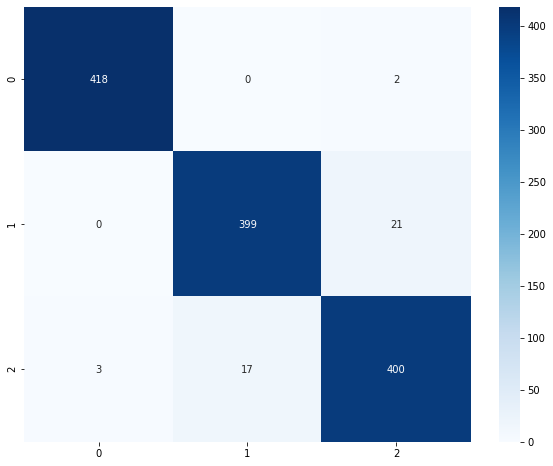

In [855]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
for i in range(d_test.shape[0]):
    predicted_list = [predicted2[i], predicted3[i], predicted1[i]]
    predicted.append(max(set(predicted_list), key=predicted_list.count))


# estadisticas
acc = accuracy_score(d_test, predicted)
print('Accuracy: ', round(acc, 3))
cmatrix = confusion_matrix(d_test, predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')

### - Clasificador Grupal:
- Ahora vamos a medir la *accuracy* para la clasificación según lo predicho en la etapa anterior. Esto se hace con un sistema de votación por cada *patch*.

In [856]:
# contadores por clase y tipo de votos
votes = {'00': {}, '01': {}, '02': {}}
for i in range(label_testing.shape[0]):
    label = label_testing[i]
    # si aún no se agrega esta clase
    if not label[4:8] in votes[label[1:3]].keys():
        votes[label[1:3]][label[4:8]] = [predicted[i]]
    else:
        votes[label[1:3]][label[4:8]].append(predicted[i])

In [857]:
# hacemos la clasificación en grupos vamos a contruir un predict and true value
group_predicted = []
group_true_value = []
for cnumber in votes:
    for gnumber in votes[cnumber]:
        group_true_value.append(int(cnumber))
        predicted_list = votes[cnumber][gnumber]
        group_predicted.append(max(set(predicted_list), key=predicted_list.count))
g_predicted = np.array(group_predicted)
g_test = np.array(group_true_value)

Accuracy:  0.992


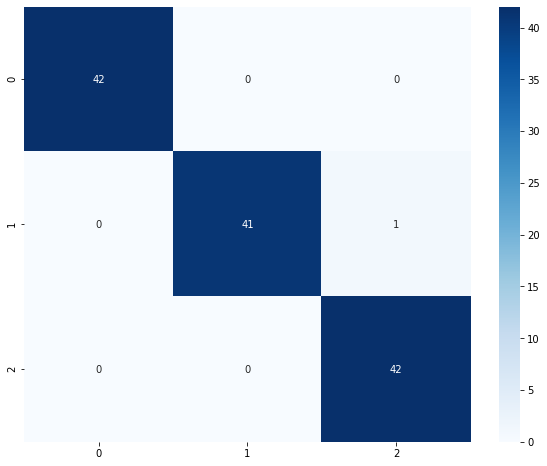

In [858]:
# estadisticas por grupos
g_acc = accuracy_score(g_test, g_predicted)
print('Accuracy: ', round(g_acc, 3))

g_cmatrix = confusion_matrix(g_test, g_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(g_cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')